In [42]:
# !pip install geopandas rasterio shapely scipy scikit-learn scikit-image seaborn matplotlib_scalebar

In [43]:
# =============================================================================
# IMPORTS
# =============================================================================
# Core libraries
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Geospatial libraries
import geopandas as gpd
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, rowcol
from rasterio.mask import mask
from rasterio import features
from shapely.geometry import Point, box

# Analysis libraries
from scipy.interpolate import griddata
from scipy.ndimage import median_filter, binary_opening, binary_closing
from scipy import stats
from sklearn.neighbors import NearestNeighbors, KernelDensity
from skimage.morphology import disk

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns

# Data I/O
from dbfread import DBF

# =============================================================================
# PATHS AND DIRECTORIES
# =============================================================================
DATA_DIR = Path("data")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)
print(DATA_DIR)
# =============================================================================
# COORDINATE REFERENCE SYSTEM
# =============================================================================
TARGET_CRS = 'EPSG:32632'  # UTM 32N

# =============================================================================
# PROCESSING PARAMETERS
# =============================================================================
COHERENCE_THRESHOLD = 0.3
NODATA = -9999
GRID_SIZE = 10  # meters

# =============================================================================
# CORINE LAND COVER CLASSES
# =============================================================================
CORINE_CLASSES = {
    1: 'Continuous urban fabric', 2: 'Discontinuous urban fabric',
    3: 'Industrial or commercial units', 4: 'Road and rail networks',
    5: 'Port areas', 6: 'Airports', 7: 'Mineral extraction sites',
    8: 'Dump sites', 9: 'Construction sites', 10: 'Green urban areas',
    11: 'Sport and leisure facilities', 12: 'Non-irrigated arable land',
    13: 'Permanently irrigated land', 14: 'Rice fields', 15: 'Vineyards',
    16: 'Fruit trees and berry plantations', 17: 'Olive groves',
    18: 'Pastures', 19: 'Annual crops with permanent crops',
    20: 'Complex cultivation patterns', 21: 'Agriculture with natural vegetation',
    22: 'Agro-forestry areas', 23: 'Broad-leaved forest',
    24: 'Coniferous forest', 25: 'Mixed forest', 26: 'Natural grasslands',
    27: 'Moors and heathland', 28: 'Sclerophyllous vegetation',
    29: 'Transitional woodland-shrub', 30: 'Beaches, dunes, sands',
    31: 'Bare rocks', 32: 'Sparsely vegetated areas', 33: 'Burnt areas',
    34: 'Glaciers and perpetual snow', 35: 'Inland marshes',
    36: 'Peat bogs', 37: 'Salt marshes', 38: 'Salines',
    39: 'Intertidal flats', 40: 'Water courses', 41: 'Water bodies',
    42: 'Coastal lagoons', 43: 'Estuaries', 44: 'Sea and ocean'
}

CORINE_COLORS = {
    1: (230, 0, 77), 2: (255, 0, 0), 3: (204, 77, 242), 4: (204, 0, 0),
    5: (230, 204, 204), 6: (230, 204, 230), 7: (166, 0, 204), 8: (166, 77, 0),
    9: (255, 77, 255), 10: (255, 166, 255), 11: (255, 230, 255),
    12: (255, 255, 168), 13: (255, 255, 0), 14: (230, 230, 0), 15: (230, 128, 0),
    16: (242, 166, 77), 17: (230, 166, 0), 18: (230, 230, 77), 19: (255, 230, 166),
    20: (255, 230, 77), 21: (230, 204, 77), 22: (242, 204, 166),
    23: (128, 255, 0), 24: (0, 166, 0), 25: (77, 255, 0), 26: (204, 242, 77),
    27: (166, 230, 77), 28: (166, 166, 230), 29: (0, 204, 0), 30: (240, 240, 240),
    31: (204, 204, 204), 32: (204, 255, 204), 33: (0, 0, 0), 34: (166, 230, 204),
    35: (166, 166, 255), 36: (77, 77, 255), 37: (204, 204, 255), 38: (230, 230, 255),
    39: (166, 166, 230), 40: (0, 204, 242), 41: (128, 242, 230), 42: (0, 255, 166),
    43: (166, 255, 230), 44: (230, 242, 255)
}

# Convert RGB (0-255) to matplotlib format (0-1)
CORINE_COLORS_MPL = {k: (r/255, g/255, b/255) for k, (r, g, b) in CORINE_COLORS.items()}
# =============================================================================
# FILE DISCOVERY
# =============================================================================
# Automatically locate data files in subdirectories
saocom_files = list((DATA_DIR / "saocom_csv").glob("*.csv"))
tinitaly_files = list((DATA_DIR / "tinitaly").glob("*.tif"))
copernicus_files = list((DATA_DIR / "copernicus").glob("*.tif"))
corine_files = list((DATA_DIR / "ground_cover").glob("*.tif"))
print(corine_files)
# Select first match for each dataset
saocom_path = saocom_files[0] if saocom_files else None
tinitaly_path = tinitaly_files[0] if tinitaly_files else None
copernicus_path = copernicus_files[0] if copernicus_files else None
corine_path = corine_files[0] if corine_files else None

# Find the corresponding .vat.dbf file for the CORINE raster
corine_dbf_path = None
if corine_path:
    corine_dbf_candidates = list((DATA_DIR / "ground_cover").glob(f"{corine_path.name}.vat.dbf"))
    corine_dbf_path = corine_dbf_candidates[0] if corine_dbf_candidates else None



data
[WindowsPath('data/ground_cover/U2018_CLC2018_V2020_20u1.tif')]


In [44]:
# =============================================================================
# LOAD SAOCOM POINT DATA
# =============================================================================
# Read CSV and standardize columns
df = pd.read_csv(saocom_path, sep=',')
df.columns = ['ID', 'SVET', 'LVET', 'LAT', 'LON', 'HEIGHT', 'HEIGHT_WRT_DEM', 'SIGMA_HEIGHT', 'COHER']

# Convert to numeric and remove invalid points
for col in ['LAT', 'LON', 'HEIGHT', 'COHER']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['LAT', 'LON', 'HEIGHT', 'COHER'])
df = df[(df['LAT'] != 0) & (df['LON'] != 0)]

# Apply coherence filter
df_filtered = df[df['COHER'] >= COHERENCE_THRESHOLD]

# Convert to GeoDataFrame and reproject to target CRS
geometry = [Point(lon, lat) for lon, lat in zip(df_filtered['LON'], df_filtered['LAT'])]
saocom_gdf = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs='EPSG:4326')
saocom_gdf = saocom_gdf.to_crs(TARGET_CRS)
saocom_gdf['x_utm'] = saocom_gdf.geometry.x
saocom_gdf['y_utm'] = saocom_gdf.geometry.y

# =============================================================================
# LOAD REFERENCE DEMS
# =============================================================================
# TINITALY
with rasterio.open(tinitaly_path) as src:
    tinitaly_crs = src.crs
    tinitaly_res = src.res
    tinitaly_bounds = src.bounds
    tinitaly_nodata = src.nodata

# Copernicus
with rasterio.open(copernicus_path) as src:
    copernicus_crs = src.crs
    copernicus_res = src.res
    copernicus_bounds = src.bounds
    copernicus_nodata = src.nodata
# =============================================================================
# LOAD AND REMAP CORINE LAND COVER
# =============================================================================
# Load DBF lookup table
dbf_table = DBF(corine_dbf_path, load=True)
lookup_df = pd.DataFrame(iter(dbf_table))

# Create mapping dictionaries
value_to_code = dict(zip(lookup_df['Value'], lookup_df['CODE_18']))
value_to_label = dict(zip(lookup_df['Value'], lookup_df['LABEL3']))
code_to_label = dict(zip(lookup_df['CODE_18'], lookup_df['LABEL3']))

# Load original CORINE raster
with rasterio.open(corine_path) as src:
    corine_raw = src.read(1)
    corine_crs = src.crs
    corine_res = src.res
    corine_bounds = src.bounds
    corine_nodata = src.nodata if src.nodata is not None else 255
    corine_transform = src.transform
    corine_profile = src.profile

# Remap raster values from Value to CODE_18
corine_remapped = np.full_like(corine_raw, 0, dtype=np.uint16)
for value, code in value_to_code.items():
    corine_remapped[corine_raw == value] = code
corine_remapped[corine_raw == corine_nodata] = 0  # NoData = 0

# Save remapped CORINE to temporary file
corine_remapped_path = RESULTS_DIR / "corine_remapped.tif"
profile_remapped = corine_profile.copy()
profile_remapped.update(dtype='uint16', nodata=0)
with rasterio.open(corine_remapped_path, 'w', **profile_remapped) as dst:
    dst.write(corine_remapped, 1)

# Update corine_path to use remapped version
corine_path = corine_remapped_path

In [45]:
# =============================================================================
# HORIZONTAL DATUM VERIFICATION
# =============================================================================
# Check if datasets need reprojection to target CRS
tinitaly_needs_reproject = str(tinitaly_crs) != TARGET_CRS
copernicus_needs_reproject = str(copernicus_crs) != TARGET_CRS
corine_needs_reproject = str(corine_crs) != TARGET_CRS

# =============================================================================
# VERTICAL DATUM VERIFICATION
# =============================================================================
# Extract vertical datum information from CRS WKT
tinitaly_wkt = tinitaly_crs.to_wkt()
copernicus_wkt = copernicus_crs.to_wkt()

# Check for vertical datum identifiers
tinitaly_vertical = 'EGM2008' in tinitaly_wkt or 'geoid' in tinitaly_wkt.lower()
copernicus_vertical = 'EGM2008' in copernicus_wkt or 'geoid' in copernicus_wkt.lower()

# Copernicus GLO-30 uses EGM2008 geoid (documented)
# TINITALY typically uses WGS84 ellipsoid (documented)

# =============================================================================
# CREATE STUDY AREA BOUNDS AND CONVEX HULL
# =============================================================================
study_bounds = saocom_gdf.total_bounds  # [xmin, ymin, xmax, ymax]
study_area_poly = box(*study_bounds)
study_area_gdf = gpd.GeoDataFrame([1], geometry=[study_area_poly], crs=TARGET_CRS)

# Create convex hull from SAOCOM points for masking
data_hull = saocom_gdf.unary_union.convex_hull
hull_gdf = gpd.GeoDataFrame(geometry=[data_hull], crs=TARGET_CRS)

# =============================================================================
# DEFINE 10M GRID PARAMETERS
# =============================================================================
xmin_grid = np.floor(study_bounds[0] / GRID_SIZE) * GRID_SIZE
ymin_grid = np.floor(study_bounds[1] / GRID_SIZE) * GRID_SIZE
xmax_grid = np.ceil(study_bounds[2] / GRID_SIZE) * GRID_SIZE
ymax_grid = np.ceil(study_bounds[3] / GRID_SIZE) * GRID_SIZE

grid_width = int((xmax_grid - xmin_grid) / GRID_SIZE)
grid_height = int((ymax_grid - ymin_grid) / GRID_SIZE)
target_transform = from_bounds(xmin_grid, ymin_grid, xmax_grid, ymax_grid, grid_width, grid_height)

# =============================================================================
# STORE REFERENCE DATASET METADATA
# =============================================================================
reference_dems = {
    'tinitaly_crop': {
        'path': tinitaly_path,
        'crs': tinitaly_crs,
        'needs_reproject': tinitaly_needs_reproject,
        'vertical_datum': 'WGS84 ellipsoid'
    },
    'copernicus': {
        'path': copernicus_path,
        'crs': copernicus_crs,
        'needs_reproject': copernicus_needs_reproject,
        'vertical_datum': 'EGM2008 geoid'
    }
}

In [46]:
# =============================================================================
# RESAMPLE TINITALY TO 10M
# =============================================================================
tinitaly_10m = np.full((grid_height, grid_width), NODATA, dtype=np.float32)

with rasterio.open(tinitaly_path) as src:
    reproject(
        source=rasterio.band(src, 1),
        destination=tinitaly_10m,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=target_transform,
        dst_crs=TARGET_CRS,
        resampling=Resampling.cubic,
        src_nodata=src.nodata,
        dst_nodata=NODATA
    )

# Save resampled TINITALY
tinitaly_10m_path = RESULTS_DIR / "tinitaly_10m.tif"
profile = {
    'driver': 'GTiff', 'dtype': 'float32', 'width': grid_width, 'height': grid_height,
    'count': 1, 'crs': TARGET_CRS, 'transform': target_transform,
    'nodata': NODATA, 'compress': 'lzw'
}
with rasterio.open(tinitaly_10m_path, 'w', **profile) as dst:
    dst.write(tinitaly_10m, 1)

# =============================================================================
# RESAMPLE COPERNICUS TO 10M
# =============================================================================
copernicus_10m = np.full((grid_height, grid_width), NODATA, dtype=np.float32)

with rasterio.open(copernicus_path) as src:
    reproject(
        source=rasterio.band(src, 1),
        destination=copernicus_10m,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=target_transform,
        dst_crs=TARGET_CRS,
        resampling=Resampling.cubic,
        src_nodata=src.nodata,
        dst_nodata=NODATA
    )

# Save resampled Copernicus
copernicus_10m_path = RESULTS_DIR / "copernicus_10m.tif"
with rasterio.open(copernicus_10m_path, 'w', **profile) as dst:
    dst.write(copernicus_10m, 1)

# =============================================================================
# RESAMPLE CORINE TO 10M
# =============================================================================
corine_10m = np.full((grid_height, grid_width), 255, dtype=np.uint8)
with rasterio.open(corine_path) as src:
    reproject(
        source=rasterio.band(src, 1),
        destination=corine_10m,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=target_transform,
        dst_crs=TARGET_CRS,
        resampling=Resampling.nearest,
        src_nodata=src.nodata if src.nodata is not None else 255,
        dst_nodata=255
    )

# Save resampled CORINE
corine_10m_path = RESULTS_DIR / "corine_10m.tif"
profile_corine = profile.copy()
profile_corine['dtype'] = 'uint8'
profile_corine['nodata'] = 255
with rasterio.open(corine_10m_path, 'w', **profile_corine) as dst:
    dst.write(corine_10m, 1)

# =============================================================================
# UPDATE REFERENCE DATASET PATHS
# =============================================================================
reference_dems['tinitaly_crop']['resampled_path'] = tinitaly_10m_path
reference_dems['tinitaly_crop']['is_10m'] = True
reference_dems['copernicus']['resampled_path'] = copernicus_10m_path
reference_dems['copernicus']['is_10m'] = True

In [47]:
# =============================================================================
# CREATE RASTERIZED MASK FROM SAOCOM CONVEX HULL
# =============================================================================
# Rasterize the convex hull polygon to match the 10m grid
hull_mask = features.rasterize(
    shapes=[data_hull],
    out_shape=(grid_height, grid_width),
    transform=target_transform,
    fill=0,
    all_touched=True,
    dtype=np.uint8
) == 1  # Convert to boolean (True inside hull)

# =============================================================================
# MASK TINITALY
# =============================================================================
tinitaly_10m_masked = tinitaly_10m.copy()
tinitaly_10m_masked[~hull_mask] = NODATA

# Save masked TINITALY
tinitaly_masked_path = RESULTS_DIR / "tinitaly_10m_masked.tif"
with rasterio.open(tinitaly_masked_path, 'w', **profile) as dst:
    dst.write(tinitaly_10m_masked, 1)

# =============================================================================
# MASK COPERNICUS
# =============================================================================
copernicus_10m_masked = copernicus_10m.copy()
copernicus_10m_masked[~hull_mask] = NODATA

# Save masked Copernicus
copernicus_masked_path = RESULTS_DIR / "copernicus_10m_masked.tif"
with rasterio.open(copernicus_masked_path, 'w', **profile) as dst:
    dst.write(copernicus_10m_masked, 1)

# =============================================================================
# MASK CORINE
# =============================================================================
corine_10m_masked = corine_10m.copy()
corine_10m_masked[~hull_mask] = 255

# Save masked CORINE
corine_masked_path = RESULTS_DIR / "corine_10m_masked.tif"
profile_corine_masked = profile.copy()
profile_corine_masked['dtype'] = 'uint8'
profile_corine_masked['nodata'] = 255
with rasterio.open(corine_masked_path, 'w', **profile_corine_masked) as dst:
    dst.write(corine_10m_masked, 1)

# =============================================================================
# UPDATE REFERENCE DATASET PATHS TO MASKED VERSIONS
# =============================================================================
reference_dems['tinitaly_crop']['masked_path'] = tinitaly_masked_path
reference_dems['copernicus']['masked_path'] = copernicus_masked_path

# Store masked arrays in memory for quick access
tinitaly_10m = tinitaly_10m_masked
copernicus_10m = copernicus_10m_masked
corine_10m = corine_10m_masked

In [66]:
# =============================================================================
# CALIBRATE SAOCOM HEIGHTS TO ABSOLUTE ELEVATIONS
# =============================================================================
# Extract reference DEM values at SAOCOM point locations
saocom_coords = list(zip(saocom_gdf['x_utm'], saocom_gdf['y_utm']))
print(saocom_gdf['HEIGHT'].min(), saocom_gdf['HEIGHT'].max())
# Sample TINITALY at SAOCOM points
with rasterio.open(tinitaly_masked_path) as src:
    tinitaly_values = list(src.sample(saocom_coords))
    saocom_gdf['tinitaly_height'] = [val[0] if val[0] != NODATA else np.nan for val in tinitaly_values]

# Sample Copernicus at SAOCOM points
with rasterio.open(copernicus_masked_path) as src:
    copernicus_values = list(src.sample(saocom_coords))
    saocom_gdf['copernicus_height'] = [val[0] if val[0] != NODATA else np.nan for val in copernicus_values]

# =============================================================================
# IDENTIFY HIGH-QUALITY CALIBRATION POINTS
# =============================================================================
calibration_mask = (saocom_gdf['COHER'] > 0.8) & \
                   (saocom_gdf['tinitaly_height'].notna()) & \
                   (np.abs(saocom_gdf['HEIGHT']) < 1000)
calibration_points = saocom_gdf[calibration_mask]

# =============================================================================
# METHOD 1: CONSTANT OFFSET
# =============================================================================
height_diff = calibration_points['tinitaly_height'] - calibration_points['HEIGHT']
offset_tinitaly = np.median(height_diff)
saocom_gdf['HEIGHT_ABSOLUTE'] = saocom_gdf['HEIGHT'] + offset_tinitaly

# =============================================================================
# METHOD 2: LINEAR REGRESSION (if systematic relationship exists)
# =============================================================================
slope, intercept, r_value, _, _ = stats.linregress(
    calibration_points['HEIGHT'],
    calibration_points['tinitaly_height']
)

if r_value**2 > 0.6:
    saocom_gdf['HEIGHT_ABSOLUTE_REG'] = intercept + slope * saocom_gdf['HEIGHT']
else:
    saocom_gdf['HEIGHT_ABSOLUTE_REG'] = saocom_gdf['HEIGHT_ABSOLUTE']

# =============================================================================
# VALIDATION
# =============================================================================
from sklearn.model_selection import train_test_split

cal_idx, val_idx = train_test_split(calibration_points.index, test_size=0.2, random_state=42)
validation_points = saocom_gdf.loc[val_idx]
val_diff = validation_points['tinitaly_height'] - validation_points['HEIGHT_ABSOLUTE']
rmse_validation = np.sqrt(np.mean(val_diff**2))
mae_validation = np.mean(np.abs(val_diff))

# =============================================================================
# CREATE CALIBRATED HEIGHT GRID
# =============================================================================
saocom_height_grid = np.full((grid_height, grid_width), np.nan, dtype=np.float32)
rows, cols = rowcol(target_transform, saocom_gdf.geometry.x.values, saocom_gdf.geometry.y.values)
valid_idx = (rows >= 0) & (rows < grid_height) & (cols >= 0) & (cols < grid_width)
saocom_height_grid[rows[valid_idx], cols[valid_idx]] = saocom_gdf['HEIGHT_ABSOLUTE'].values[valid_idx]
print(())

-562.0 1163.7
()


In [49]:
# =============================================================================
# CREATE SAOCOM COVERAGE GRID
# =============================================================================
# Initialize coverage array matching the 10m grid
saocom_coverage = np.zeros((grid_height, grid_width), dtype=bool)

# Convert SAOCOM points to grid indices
saocom_rows, saocom_cols = rowcol(target_transform,
                                   saocom_gdf.geometry.x.values,
                                   saocom_gdf.geometry.y.values)

# Mark cells with SAOCOM data
valid_indices = ((saocom_rows >= 0) & (saocom_rows < grid_height) &
                 (saocom_cols >= 0) & (saocom_cols < grid_width))
saocom_coverage[saocom_rows[valid_indices], saocom_cols[valid_indices]] = True

# =============================================================================
# CALCULATE OVERALL VOID STATISTICS
# =============================================================================
# Study area mask (inside hull, excluding nodata)
study_area_mask = hull_mask & (corine_10m != 0)

# Void mask (study area cells without SAOCOM data)
void_mask = study_area_mask & (~saocom_coverage)

n_total_cells = np.sum(study_area_mask)
n_occupied_cells = np.sum(study_area_mask & saocom_coverage)
n_void_cells = np.sum(void_mask)
void_percentage = 100 * n_void_cells / n_total_cells if n_total_cells > 0 else 0
# =============================================================================
# VOID ANALYSIS BY LAND COVER CLASS
# =============================================================================
unique_lc_codes = np.unique(corine_10m[study_area_mask])
void_stats_by_lc = []

for lc_code in unique_lc_codes:
    if lc_code == 0:  # Skip nodata
        continue

    # Mask for this land cover class within study area
    lc_mask = study_area_mask & (corine_10m == lc_code)

    # Total cells of this land cover
    total_lc_cells = np.sum(lc_mask)

    # Void cells within this land cover
    void_lc_cells = np.sum(lc_mask & void_mask)

    # METRIC 1: What % of this land cover is void?
    pct_of_lc_that_is_void = 100 * void_lc_cells / total_lc_cells if total_lc_cells > 0 else 0

    # METRIC 2: What % of total voids is this land cover?
    pct_of_total_voids = 100 * void_lc_cells / n_void_cells if n_void_cells > 0 else 0

    void_stats_by_lc.append({
        'corine_code': lc_code,
        'label': code_to_label.get(lc_code, f'Unknown_{lc_code}'),
        'total_cells': total_lc_cells,
        'void_cells': void_lc_cells,
        'occupied_cells': total_lc_cells - void_lc_cells,
        'pct_of_lc_that_is_void': pct_of_lc_that_is_void,
        'pct_of_total_voids': pct_of_total_voids,
        'area_km2': total_lc_cells * 0.0001
    })

# Create DataFrame and sort by total area
void_stats_df = pd.DataFrame(void_stats_by_lc)
void_stats_df = void_stats_df.sort_values('area_km2', ascending=False)


# =============================================================================
# SAVE VOID MASK AS RASTER
# =============================================================================
void_mask_path = RESULTS_DIR / "saocom_void_mask.tif"
profile_void = profile.copy()
profile_void['dtype'] = 'uint8'
profile_void['nodata'] = 255
void_raster = np.full((grid_height, grid_width), 255, dtype=np.uint8)
void_raster[study_area_mask] = 0  # Data area
void_raster[void_mask] = 1  # Void cells



In [50]:
# =============================================================================
# LOAD REFERENCE DEM DATA (Already in memory from Cell 4)
# =============================================================================
tinitaly_data = tinitaly_10m.copy()
copernicus_data = copernicus_10m.copy()

# =============================================================================
# CALCULATE ELEVATION DIFFERENCE (TINITALY - COPERNICUS)
# =============================================================================
elevation_diff = tinitaly_data - copernicus_data

# =============================================================================
# CREATE VALID COMPARISON MASK
# =============================================================================
valid_mask = (tinitaly_data != NODATA) & (copernicus_data != NODATA)

# Extract valid data for statistics
valid_pixels = np.sum(valid_mask)
valid_diffs = elevation_diff[valid_mask]
valid_tinitaly = tinitaly_data[valid_mask]
valid_copernicus = copernicus_data[valid_mask]

# =============================================================================
# CALCULATE REFERENCE COMPARISON STATISTICS
# =============================================================================
ref_metrics = {
    'n_pixels': valid_pixels,
    'mean_diff': np.mean(valid_diffs),
    'median_diff': np.median(valid_diffs),
    'std_diff': np.std(valid_diffs),
    'rmse': np.sqrt(np.mean(valid_diffs**2)),
    'mae': np.mean(np.abs(valid_diffs)),
    'nmad': 1.4826 * np.median(np.abs(valid_diffs - np.median(valid_diffs))),
    'min_diff': np.min(valid_diffs),
    'max_diff': np.max(valid_diffs),
    'correlation': np.corrcoef(valid_tinitaly, valid_copernicus)[0, 1]
}

# =============================================================================
# DEFINE EQUALITY TOLERANCE USING NMAD
# =============================================================================
# Use NMAD as statistical threshold for "roughly equal"
equal_tolerance = ref_metrics['nmad']
# =============================================================================
# DIRECTIONAL COMPARISON GRIDS WITH EQUALITY BUFFER
# =============================================================================
# Where TINITALY significantly > Copernicus
tinitaly_higher_mask = (valid_mask) & (elevation_diff > equal_tolerance)
tinitaly_higher_data = np.full_like(elevation_diff, np.nan)
tinitaly_higher_data[tinitaly_higher_mask] = elevation_diff[tinitaly_higher_mask]

# Where TINITALY significantly < Copernicus
tinitaly_lower_mask = (valid_mask) & (elevation_diff < -equal_tolerance)
tinitaly_lower_data = np.full_like(elevation_diff, np.nan)
tinitaly_lower_data[tinitaly_lower_mask] = elevation_diff[tinitaly_lower_mask]

# Where TINITALY ≈ Copernicus (within tolerance)
roughly_equal_mask = (valid_mask) & (np.abs(elevation_diff) <= equal_tolerance)
roughly_equal_data = np.full_like(elevation_diff, np.nan)
roughly_equal_data[roughly_equal_mask] = elevation_diff[roughly_equal_mask]

# Pixel counts and percentages
higher_pixels = np.sum(tinitaly_higher_mask)
lower_pixels = np.sum(tinitaly_lower_mask)
equal_pixels = np.sum(roughly_equal_mask)

pct_higher = 100 * higher_pixels / valid_pixels
pct_lower = 100 * lower_pixels / valid_pixels
pct_equal = 100 * equal_pixels / valid_pixels

In [51]:
# =============================================================================
# SAOCOM VS TINITALY COMPARISON
# =============================================================================
# Extract valid comparisons (where both datasets have data)
saocom_tinitaly_mask = (saocom_gdf['HEIGHT_ABSOLUTE'].notna()) & (saocom_gdf['tinitaly_height'].notna())
saocom_tinitaly_valid = saocom_gdf[saocom_tinitaly_mask]

# Calculate differences
saocom_tinitaly_diff = (saocom_tinitaly_valid['HEIGHT_ABSOLUTE'] -
                        saocom_tinitaly_valid['tinitaly_height']).values

# Calculate statistics
saocom_tinitaly_metrics = {
    'n_points': len(saocom_tinitaly_diff),
    'mean_diff': np.mean(saocom_tinitaly_diff),
    'median_diff': np.median(saocom_tinitaly_diff),
    'std_diff': np.std(saocom_tinitaly_diff),
    'rmse': np.sqrt(np.mean(saocom_tinitaly_diff**2)),
    'mae': np.mean(np.abs(saocom_tinitaly_diff)),
    'nmad': 1.4826 * np.median(np.abs(saocom_tinitaly_diff - np.median(saocom_tinitaly_diff))),
    'min_diff': np.min(saocom_tinitaly_diff),
    'max_diff': np.max(saocom_tinitaly_diff),
    'correlation': np.corrcoef(saocom_tinitaly_valid['HEIGHT_ABSOLUTE'].values,
                               saocom_tinitaly_valid['tinitaly_height'].values)[0, 1]
}

# Define tolerance and create directional classifications
saocom_tinitaly_tolerance = saocom_tinitaly_metrics['nmad']

saocom_tinitaly_higher_mask = saocom_tinitaly_diff > saocom_tinitaly_tolerance
saocom_tinitaly_lower_mask = saocom_tinitaly_diff < -saocom_tinitaly_tolerance
saocom_tinitaly_equal_mask = np.abs(saocom_tinitaly_diff) <= saocom_tinitaly_tolerance

saocom_tinitaly_higher_count = np.sum(saocom_tinitaly_higher_mask)
saocom_tinitaly_lower_count = np.sum(saocom_tinitaly_lower_mask)
saocom_tinitaly_equal_count = np.sum(saocom_tinitaly_equal_mask)

saocom_tinitaly_pct_higher = 100 * saocom_tinitaly_higher_count / len(saocom_tinitaly_diff)
saocom_tinitaly_pct_lower = 100 * saocom_tinitaly_lower_count / len(saocom_tinitaly_diff)
saocom_tinitaly_pct_equal = 100 * saocom_tinitaly_equal_count / len(saocom_tinitaly_diff)

# =============================================================================
# SAOCOM VS COPERNICUS COMPARISON
# =============================================================================
saocom_copernicus_mask = (saocom_gdf['HEIGHT_ABSOLUTE'].notna()) & (saocom_gdf['copernicus_height'].notna())
saocom_copernicus_valid = saocom_gdf[saocom_copernicus_mask]

saocom_copernicus_diff = (saocom_copernicus_valid['HEIGHT_ABSOLUTE'] -
                          saocom_copernicus_valid['copernicus_height']).values

saocom_copernicus_metrics = {
    'n_points': len(saocom_copernicus_diff),
    'mean_diff': np.mean(saocom_copernicus_diff),
    'median_diff': np.median(saocom_copernicus_diff),
    'std_diff': np.std(saocom_copernicus_diff),
    'rmse': np.sqrt(np.mean(saocom_copernicus_diff**2)),
    'mae': np.mean(np.abs(saocom_copernicus_diff)),
    'nmad': 1.4826 * np.median(np.abs(saocom_copernicus_diff - np.median(saocom_copernicus_diff))),
    'min_diff': np.min(saocom_copernicus_diff),
    'max_diff': np.max(saocom_copernicus_diff),
    'correlation': np.corrcoef(saocom_copernicus_valid['HEIGHT_ABSOLUTE'].values,
                               saocom_copernicus_valid['copernicus_height'].values)[0, 1]
}

saocom_copernicus_tolerance = saocom_copernicus_metrics['nmad']

saocom_copernicus_higher_mask = saocom_copernicus_diff > saocom_copernicus_tolerance
saocom_copernicus_lower_mask = saocom_copernicus_diff < -saocom_copernicus_tolerance
saocom_copernicus_equal_mask = np.abs(saocom_copernicus_diff) <= saocom_copernicus_tolerance

saocom_copernicus_higher_count = np.sum(saocom_copernicus_higher_mask)
saocom_copernicus_lower_count = np.sum(saocom_copernicus_lower_mask)
saocom_copernicus_equal_count = np.sum(saocom_copernicus_equal_mask)

saocom_copernicus_pct_higher = 100 * saocom_copernicus_higher_count / len(saocom_copernicus_diff)
saocom_copernicus_pct_lower = 100 * saocom_copernicus_lower_count / len(saocom_copernicus_diff)
saocom_copernicus_pct_equal = 100 * saocom_copernicus_equal_count / len(saocom_copernicus_diff)

In [62]:
# Check for extreme values
print("SAOCOM HEIGHT_ABSOLUTE range:", saocom_gdf['HEIGHT_ABSOLUTE'].min(), saocom_gdf['HEIGHT_ABSOLUTE'].max())
print("TINITALY sampled range:", saocom_gdf['tinitaly_height'].min(), saocom_gdf['tinitaly_height'].max())
print("Points with |difference| > 100m:", np.sum(np.abs(saocom_tinitaly_diff) > 100))

SAOCOM HEIGHT_ABSOLUTE range: -558.3457412719727 1167.3542587280274
TINITALY sampled range: 99.38934 802.0969
Points with |difference| > 100m: 13564


Next Steps
Land Cover Generation
All Land Cover comparisons
Saocom comparisons


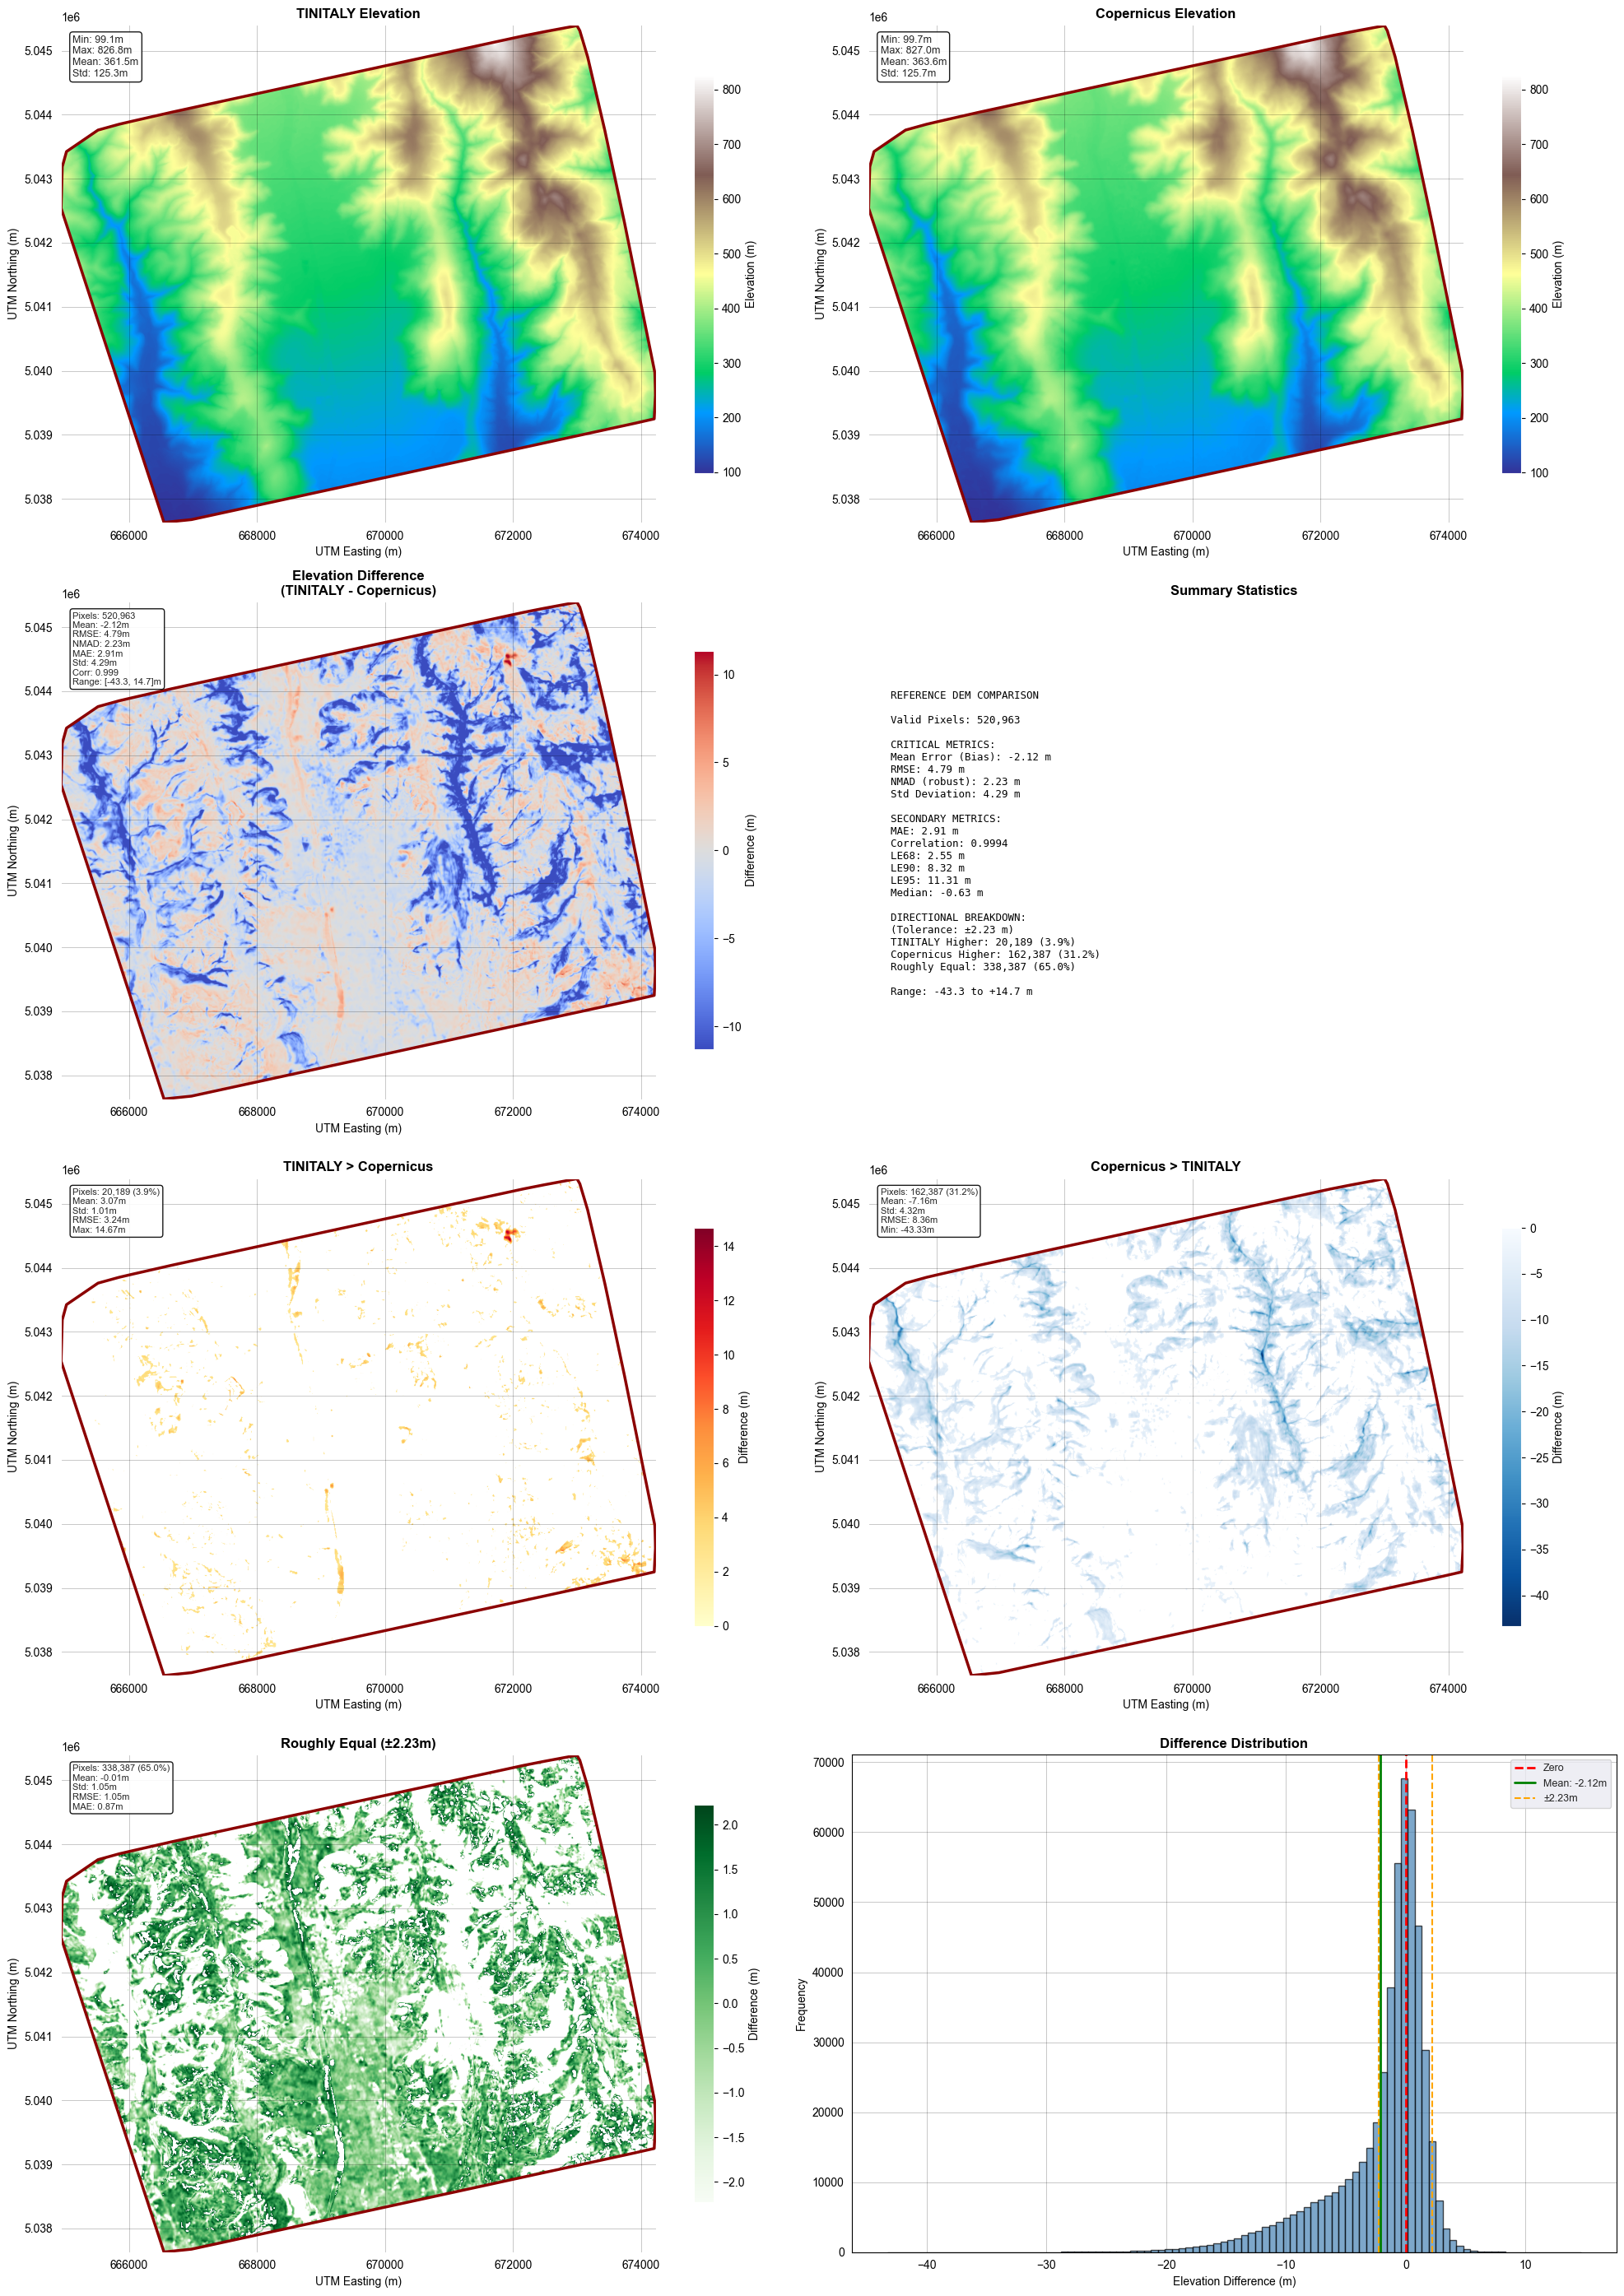

In [52]:
# =============================================================================
# COMPREHENSIVE REFERENCE DEM COMPARISON VISUALIZATION
# =============================================================================
fig, axes = plt.subplots(4, 2, figs ize=(20, 28), facecolor='white')

extent = [xmin_grid, xmax_grid, ymin_grid, ymax_grid]

# Plot 1: TINITALY elevation
ax = axes[0, 0]
ax.set_facecolor('white')
tinitaly_display = np.ma.masked_where(tinitaly_data == NODATA, tinitaly_data)
cmap1 = plt.cm.terrain.copy()
cmap1.set_bad(color='white', alpha=0)
im1 = ax.imshow(tinitaly_display, cmap=cmap1, origin='upper', extent=extent)
hull_gdf.boundary.plot(ax=ax, color='darkred', linewidth=2.5, label='Study Area')
ax.set_title('TINITALY Elevation', fontweight='bold', fontsize=12, color='black')
ax.set_xlabel('UTM Easting (m)', color='black')
ax.set_ylabel('UTM Northing (m)', color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
cbar1 = plt.colorbar(im1, ax=ax, label='Elevation (m)', shrink=0.8)
cbar1.ax.yaxis.label.set_color('black')
cbar1.ax.tick_params(colors='black')
stats1 = f"""Min: {np.nanmin(tinitaly_display):.1f}m
Max: {np.nanmax(tinitaly_display):.1f}m
Mean: {np.nanmean(tinitaly_display):.1f}m
Std: {np.nanstd(tinitaly_display):.1f}m"""
ax.text(0.02, 0.98, stats1, transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 2: Copernicus elevation
ax = axes[0, 1]
ax.set_facecolor('white')
copernicus_display = np.ma.masked_where(copernicus_data == NODATA, copernicus_data)
cmap2 = plt.cm.terrain.copy()
cmap2.set_bad(color='white', alpha=0)
im2 = ax.imshow(copernicus_display, cmap=cmap2, origin='upper', extent=extent)
hull_gdf.boundary.plot(ax=ax, color='darkred', linewidth=2.5, label='Study Area')
ax.set_title('Copernicus Elevation', fontweight='bold', fontsize=12, color='black')
ax.set_xlabel('UTM Easting (m)', color='black')
ax.set_ylabel('UTM Northing (m)', color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
cbar2 = plt.colorbar(im2, ax=ax, label='Elevation (m)', shrink=0.8)
cbar2.ax.yaxis.label.set_color('black')
cbar2.ax.tick_params(colors='black')
stats2 = f"""Min: {np.nanmin(copernicus_display):.1f}m
Max: {np.nanmax(copernicus_display):.1f}m
Mean: {np.nanmean(copernicus_display):.1f}m
Std: {np.nanstd(copernicus_display):.1f}m"""
ax.text(0.02, 0.98, stats2, transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 3: Difference map (full)
ax = axes[1, 0]
ax.set_facecolor('white')
diff_display = np.ma.masked_where(~valid_mask, elevation_diff)
diff_limit = np.percentile(np.abs(valid_diffs), 95)
cmap3 = plt.cm.coolwarm.copy()
cmap3.set_bad(color='white', alpha=0)
im3 = ax.imshow(diff_display, cmap=cmap3, origin='upper', extent=extent,
                vmin=-diff_limit, vmax=diff_limit)
hull_gdf.boundary.plot(ax=ax, color='darkred', linewidth=2.5, label='Study Area')
ax.set_title(f'Elevation Difference\n(TINITALY - Copernicus)', fontweight='bold', fontsize=12, color='black')
ax.set_xlabel('UTM Easting (m)', color='black')
ax.set_ylabel('UTM Northing (m)', color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
cbar3 = plt.colorbar(im3, ax=ax, label='Difference (m)', shrink=0.8)
cbar3.ax.yaxis.label.set_color('black')
cbar3.ax.tick_params(colors='black')
stats3 = f"""Pixels: {valid_pixels:,}
Mean: {ref_metrics['mean_diff']:+.2f}m
RMSE: {ref_metrics['rmse']:.2f}m
NMAD: {ref_metrics['nmad']:.2f}m
MAE: {ref_metrics['mae']:.2f}m
Std: {ref_metrics['std_diff']:.2f}m
Corr: {ref_metrics['correlation']:.3f}
Range: [{ref_metrics['min_diff']:.1f}, {ref_metrics['max_diff']:.1f}]m"""
ax.text(0.02, 0.98, stats3, transform=ax.transAxes, fontsize=8, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 4: Statistics summary
ax = axes[1, 1]
ax.set_facecolor('white')
le68 = np.percentile(np.abs(valid_diffs), 68.27)
le90 = np.percentile(np.abs(valid_diffs), 90)
le95 = np.percentile(np.abs(valid_diffs), 95)
stats_text = f"""REFERENCE DEM COMPARISON

Valid Pixels: {valid_pixels:,}

CRITICAL METRICS:
Mean Error (Bias): {ref_metrics['mean_diff']:+.2f} m
RMSE: {ref_metrics['rmse']:.2f} m
NMAD (robust): {ref_metrics['nmad']:.2f} m
Std Deviation: {ref_metrics['std_diff']:.2f} m

SECONDARY METRICS:
MAE: {ref_metrics['mae']:.2f} m
Correlation: {ref_metrics['correlation']:.4f}
LE68: {le68:.2f} m
LE90: {le90:.2f} m
LE95: {le95:.2f} m
Median: {ref_metrics['median_diff']:+.2f} m

DIRECTIONAL BREAKDOWN:
(Tolerance: ±{equal_tolerance:.2f} m)
TINITALY Higher: {higher_pixels:,} ({pct_higher:.1f}%)
Copernicus Higher: {lower_pixels:,} ({pct_lower:.1f}%)
Roughly Equal: {equal_pixels:,} ({pct_equal:.1f}%)

Range: {ref_metrics['min_diff']:+.1f} to {ref_metrics['max_diff']:+.1f} m
"""
ax.text(0.05, 0.5, stats_text, transform=ax.transAxes,
        fontfamily='monospace', fontsize=9, verticalalignment='center', color='black')
ax.axis('off')
ax.set_title('Summary Statistics', fontweight='bold', fontsize=12, color='black')

# Plot 5: Where TINITALY > Copernicus
ax = axes[2, 0]
ax.set_facecolor('white')
cmap5 = plt.cm.YlOrRd.copy()
cmap5.set_bad(color='white', alpha=0)
im5 = ax.imshow(tinitaly_higher_data, cmap=cmap5, origin='upper', extent=extent,
                vmin=0, vmax=np.nanmax(tinitaly_higher_data))
hull_gdf.boundary.plot(ax=ax, color='darkred', linewidth=2.5, label='Study Area')
ax.set_title(f'TINITALY > Copernicus', fontweight='bold', fontsize=12, color='black')
ax.set_xlabel('UTM Easting (m)', color='black')
ax.set_ylabel('UTM Northing (m)', color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
cbar5 = plt.colorbar(im5, ax=ax, label='Difference (m)', shrink=0.8)
cbar5.ax.yaxis.label.set_color('black')
cbar5.ax.tick_params(colors='black')
higher_vals = tinitaly_higher_data[~np.isnan(tinitaly_higher_data)]
stats5 = f"""Pixels: {higher_pixels:,} ({pct_higher:.1f}%)
Mean: {np.mean(higher_vals):.2f}m
Std: {np.std(higher_vals):.2f}m
RMSE: {np.sqrt(np.mean(higher_vals**2)):.2f}m
Max: {np.max(higher_vals):.2f}m"""
ax.text(0.02, 0.98, stats5, transform=ax.transAxes, fontsize=8, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 6: Where TINITALY < Copernicus
ax = axes[2, 1]
ax.set_facecolor('white')
cmap6 = plt.cm.Blues_r.copy()
cmap6.set_bad(color='white', alpha=0)
im6 = ax.imshow(tinitaly_lower_data, cmap=cmap6, origin='upper', extent=extent,
                vmin=np.nanmin(tinitaly_lower_data), vmax=0)
hull_gdf.boundary.plot(ax=ax, color='darkred', linewidth=2.5, label='Study Area')
ax.set_title(f'Copernicus > TINITALY', fontweight='bold', fontsize=12, color='black')
ax.set_xlabel('UTM Easting (m)', color='black')
ax.set_ylabel('UTM Northing (m)', color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
cbar6 = plt.colorbar(im6, ax=ax, label='Difference (m)', shrink=0.8)
cbar6.ax.yaxis.label.set_color('black')
cbar6.ax.tick_params(colors='black')
lower_vals = tinitaly_lower_data[~np.isnan(tinitaly_lower_data)]
stats6 = f"""Pixels: {lower_pixels:,} ({pct_lower:.1f}%)
Mean: {np.mean(lower_vals):.2f}m
Std: {np.std(lower_vals):.2f}m
RMSE: {np.sqrt(np.mean(lower_vals**2)):.2f}m
Min: {np.min(lower_vals):.2f}m"""
ax.text(0.02, 0.98, stats6, transform=ax.transAxes, fontsize=8, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 7: Where roughly equal
ax = axes[3, 0]
ax.set_facecolor('white')
cmap7 = plt.cm.Greens.copy()
cmap7.set_bad(color='white', alpha=0)
im7 = ax.imshow(roughly_equal_data, cmap=cmap7, origin='upper', extent=extent,
                vmin=-equal_tolerance, vmax=equal_tolerance)
hull_gdf.boundary.plot(ax=ax, color='darkred', linewidth=2.5, label='Study Area')
ax.set_title(f'Roughly Equal (±{equal_tolerance:.2f}m)', fontweight='bold', fontsize=12, color='black')
ax.set_xlabel('UTM Easting (m)', color='black')
ax.set_ylabel('UTM Northing (m)', color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
cbar7 = plt.colorbar(im7, ax=ax, label='Difference (m)', shrink=0.8)
cbar7.ax.yaxis.label.set_color('black')
cbar7.ax.tick_params(colors='black')
equal_vals = roughly_equal_data[~np.isnan(roughly_equal_data)]
stats7 = f"""Pixels: {equal_pixels:,} ({pct_equal:.1f}%)
Mean: {np.mean(equal_vals):.2f}m
Std: {np.std(equal_vals):.2f}m
RMSE: {np.sqrt(np.mean(equal_vals**2)):.2f}m
MAE: {np.mean(np.abs(equal_vals)):.2f}m"""
ax.text(0.02, 0.98, stats7, transform=ax.transAxes, fontsize=8, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 8: Histogram of differences
ax = axes[3, 1]
ax.set_facecolor('white')
ax.hist(valid_diffs, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax.axvline(ref_metrics['mean_diff'], color='green', linestyle='-', linewidth=2,
           label=f'Mean: {ref_metrics["mean_diff"]:+.2f}m')
ax.axvline(equal_tolerance, color='orange', linestyle='--', linewidth=1.5,
           label=f'±{equal_tolerance:.2f}m')
ax.axvline(-equal_tolerance, color='orange', linestyle='--', linewidth=1.5)
ax.set_xlabel('Elevation Difference (m)', color='black')
ax.set_ylabel('Frequency', color='black')
ax.set_title('Difference Distribution', fontweight='bold', fontsize=12, color='black')
ax.tick_params(colors='black')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3, color='black', linewidth=0.5)
for spine in ax.spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
# plt.savefig(RESULTS_DIR / 'reference_dem_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

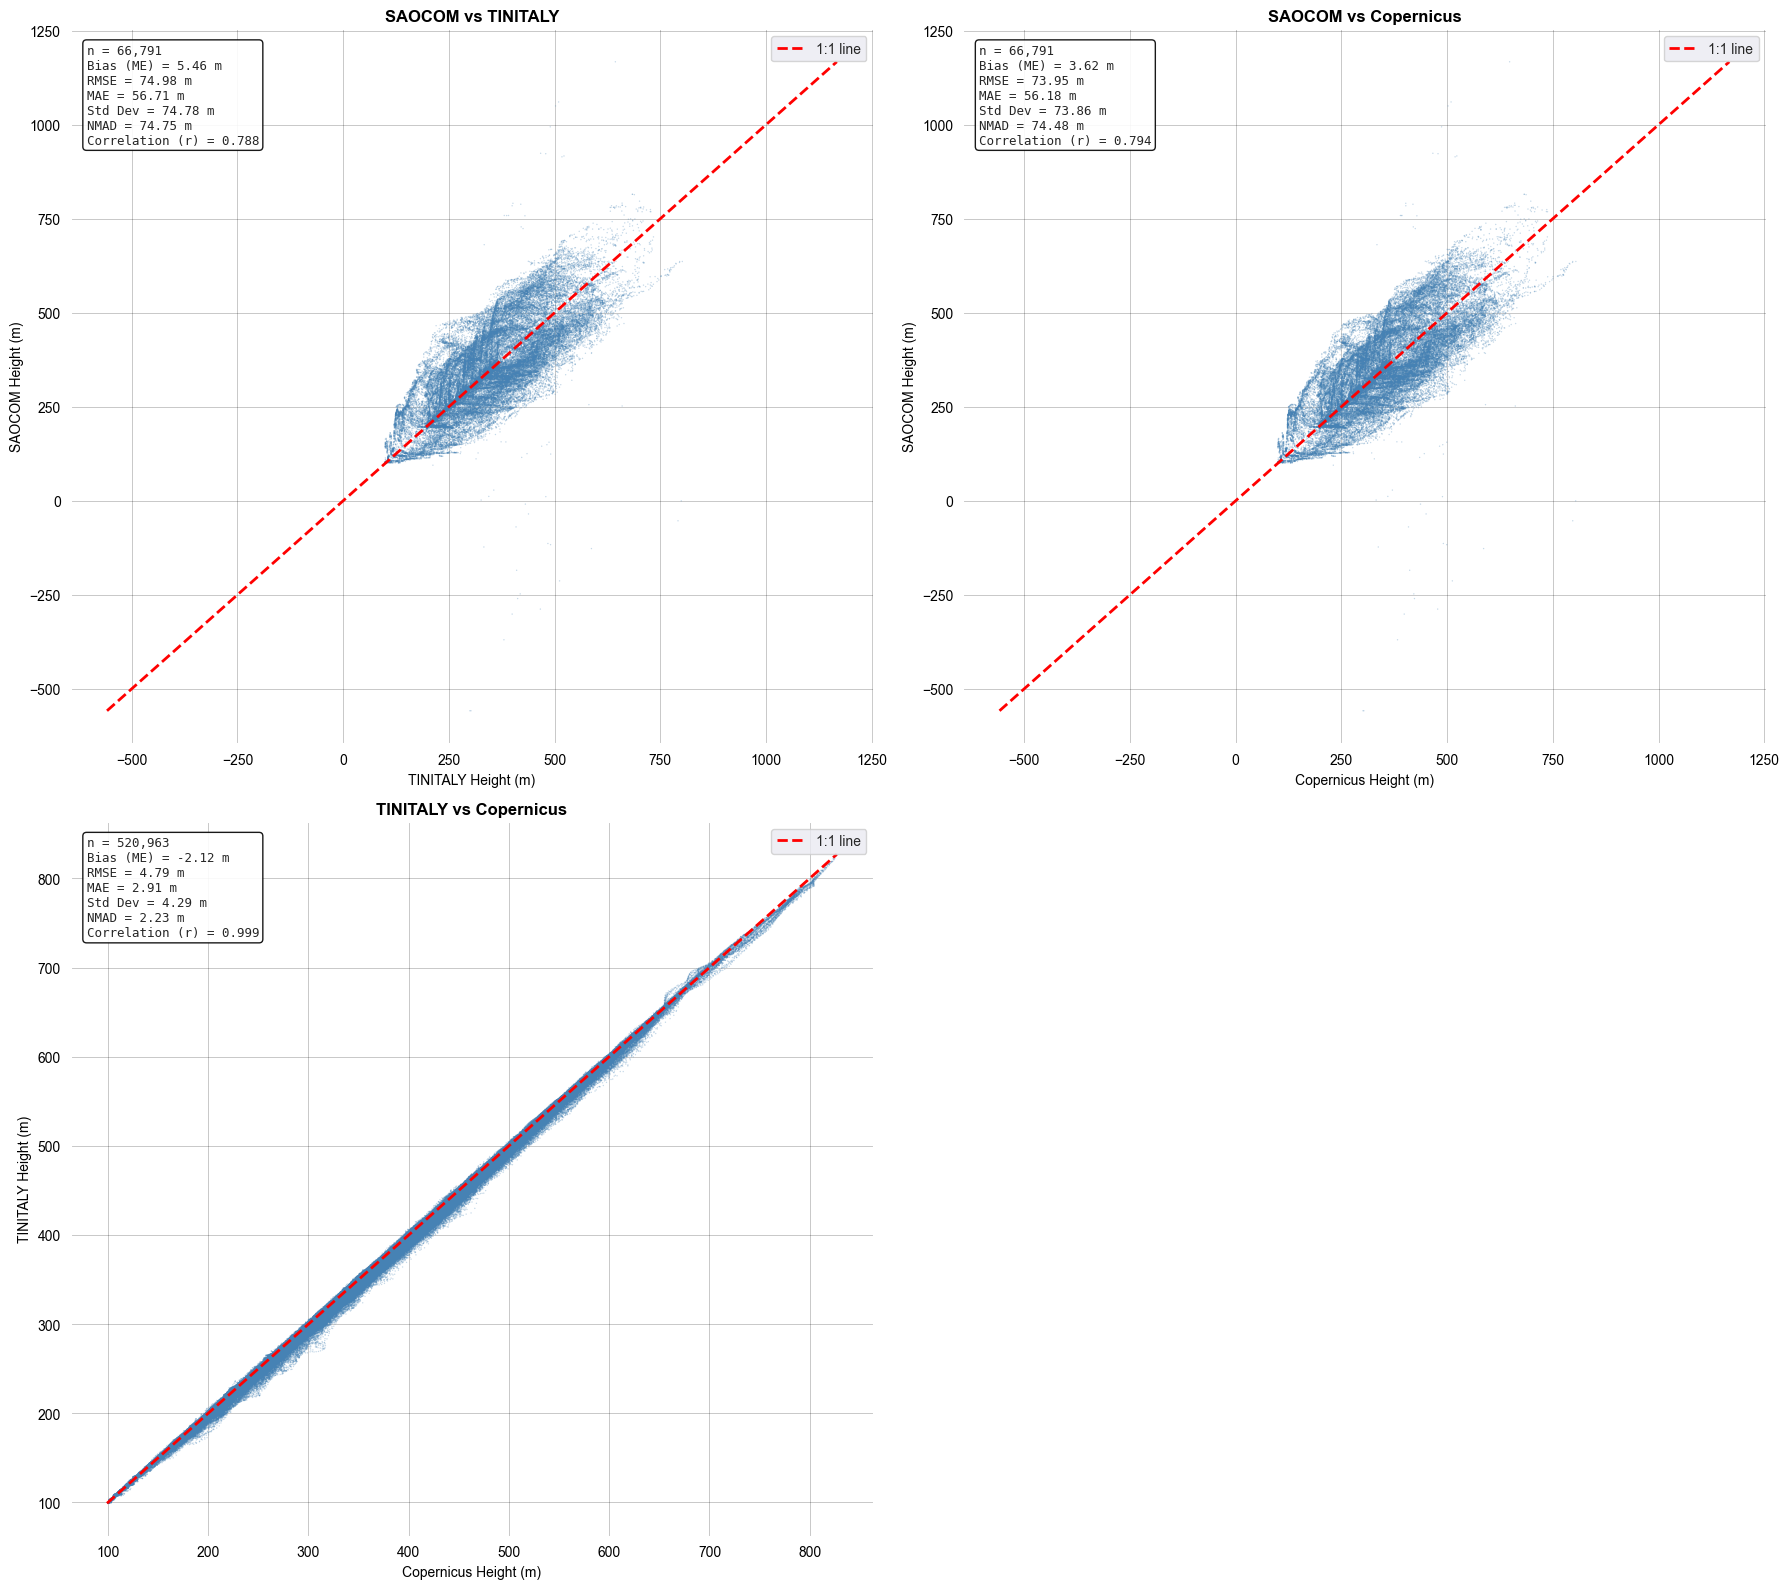

In [53]:
# =============================================================================
# SCATTER PLOT COMPARISONS - POINT DENSITY
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(18, 16), facecolor='white')

# Plot 1: SAOCOM vs TINITALY
ax = axes[0, 0]
ax.set_facecolor('white')
valid_st = saocom_tinitaly_valid[['HEIGHT_ABSOLUTE', 'tinitaly_height']].dropna()
ax.scatter(valid_st['tinitaly_height'], valid_st['HEIGHT_ABSOLUTE'],
           s=1, alpha=0.3, c='steelblue', edgecolors='none')
min_val = min(valid_st['tinitaly_height'].min(), valid_st['HEIGHT_ABSOLUTE'].min())
max_val = max(valid_st['tinitaly_height'].max(), valid_st['HEIGHT_ABSOLUTE'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 line')
ax.set_xlabel('TINITALY Height (m)', color='black')
ax.set_ylabel('SAOCOM Height (m)', color='black')
ax.set_title('SAOCOM vs TINITALY', fontweight='bold', fontsize=12, color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
ax.legend()
stats_text = f"""n = {saocom_tinitaly_metrics['n_points']:,}
Bias (ME) = {saocom_tinitaly_metrics['mean_diff']:.2f} m
RMSE = {saocom_tinitaly_metrics['rmse']:.2f} m
MAE = {saocom_tinitaly_metrics['mae']:.2f} m
Std Dev = {saocom_tinitaly_metrics['std_diff']:.2f} m
NMAD = {saocom_tinitaly_metrics['nmad']:.2f} m
Correlation (r) = {saocom_tinitaly_metrics['correlation']:.3f}"""
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 2: SAOCOM vs Copernicus
ax = axes[0, 1]
ax.set_facecolor('white')
valid_sc = saocom_copernicus_valid[['HEIGHT_ABSOLUTE', 'copernicus_height']].dropna()
ax.scatter(valid_sc['copernicus_height'], valid_sc['HEIGHT_ABSOLUTE'],
           s=1, alpha=0.3, c='steelblue', edgecolors='none')
min_val = min(valid_sc['copernicus_height'].min(), valid_sc['HEIGHT_ABSOLUTE'].min())
max_val = max(valid_sc['copernicus_height'].max(), valid_sc['HEIGHT_ABSOLUTE'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 line')
ax.set_xlabel('Copernicus Height (m)', color='black')
ax.set_ylabel('SAOCOM Height (m)', color='black')
ax.set_title('SAOCOM vs Copernicus', fontweight='bold', fontsize=12, color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
ax.legend()
stats_text = f"""n = {saocom_copernicus_metrics['n_points']:,}
Bias (ME) = {saocom_copernicus_metrics['mean_diff']:.2f} m
RMSE = {saocom_copernicus_metrics['rmse']:.2f} m
MAE = {saocom_copernicus_metrics['mae']:.2f} m
Std Dev = {saocom_copernicus_metrics['std_diff']:.2f} m
NMAD = {saocom_copernicus_metrics['nmad']:.2f} m
Correlation (r) = {saocom_copernicus_metrics['correlation']:.3f}"""
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 3: Copernicus vs TINITALY
ax = axes[1, 0]
ax.set_facecolor('white')
ax.scatter(valid_copernicus, valid_tinitaly, s=1, alpha=0.3, c='steelblue', edgecolors='none')
min_val = min(valid_copernicus.min(), valid_tinitaly.min())
max_val = max(valid_copernicus.max(), valid_tinitaly.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='1:1 line')
ax.set_xlabel('Copernicus Height (m)', color='black')
ax.set_ylabel('TINITALY Height (m)', color='black')
ax.set_title('TINITALY vs Copernicus', fontweight='bold', fontsize=12, color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
ax.legend()
stats_text = f"""n = {ref_metrics['n_pixels']:,}
Bias (ME) = {ref_metrics['mean_diff']:.2f} m
RMSE = {ref_metrics['rmse']:.2f} m
MAE = {ref_metrics['mae']:.2f} m
Std Dev = {ref_metrics['std_diff']:.2f} m
NMAD = {ref_metrics['nmad']:.2f} m
Correlation (r) = {ref_metrics['correlation']:.3f}"""
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Hide unused subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

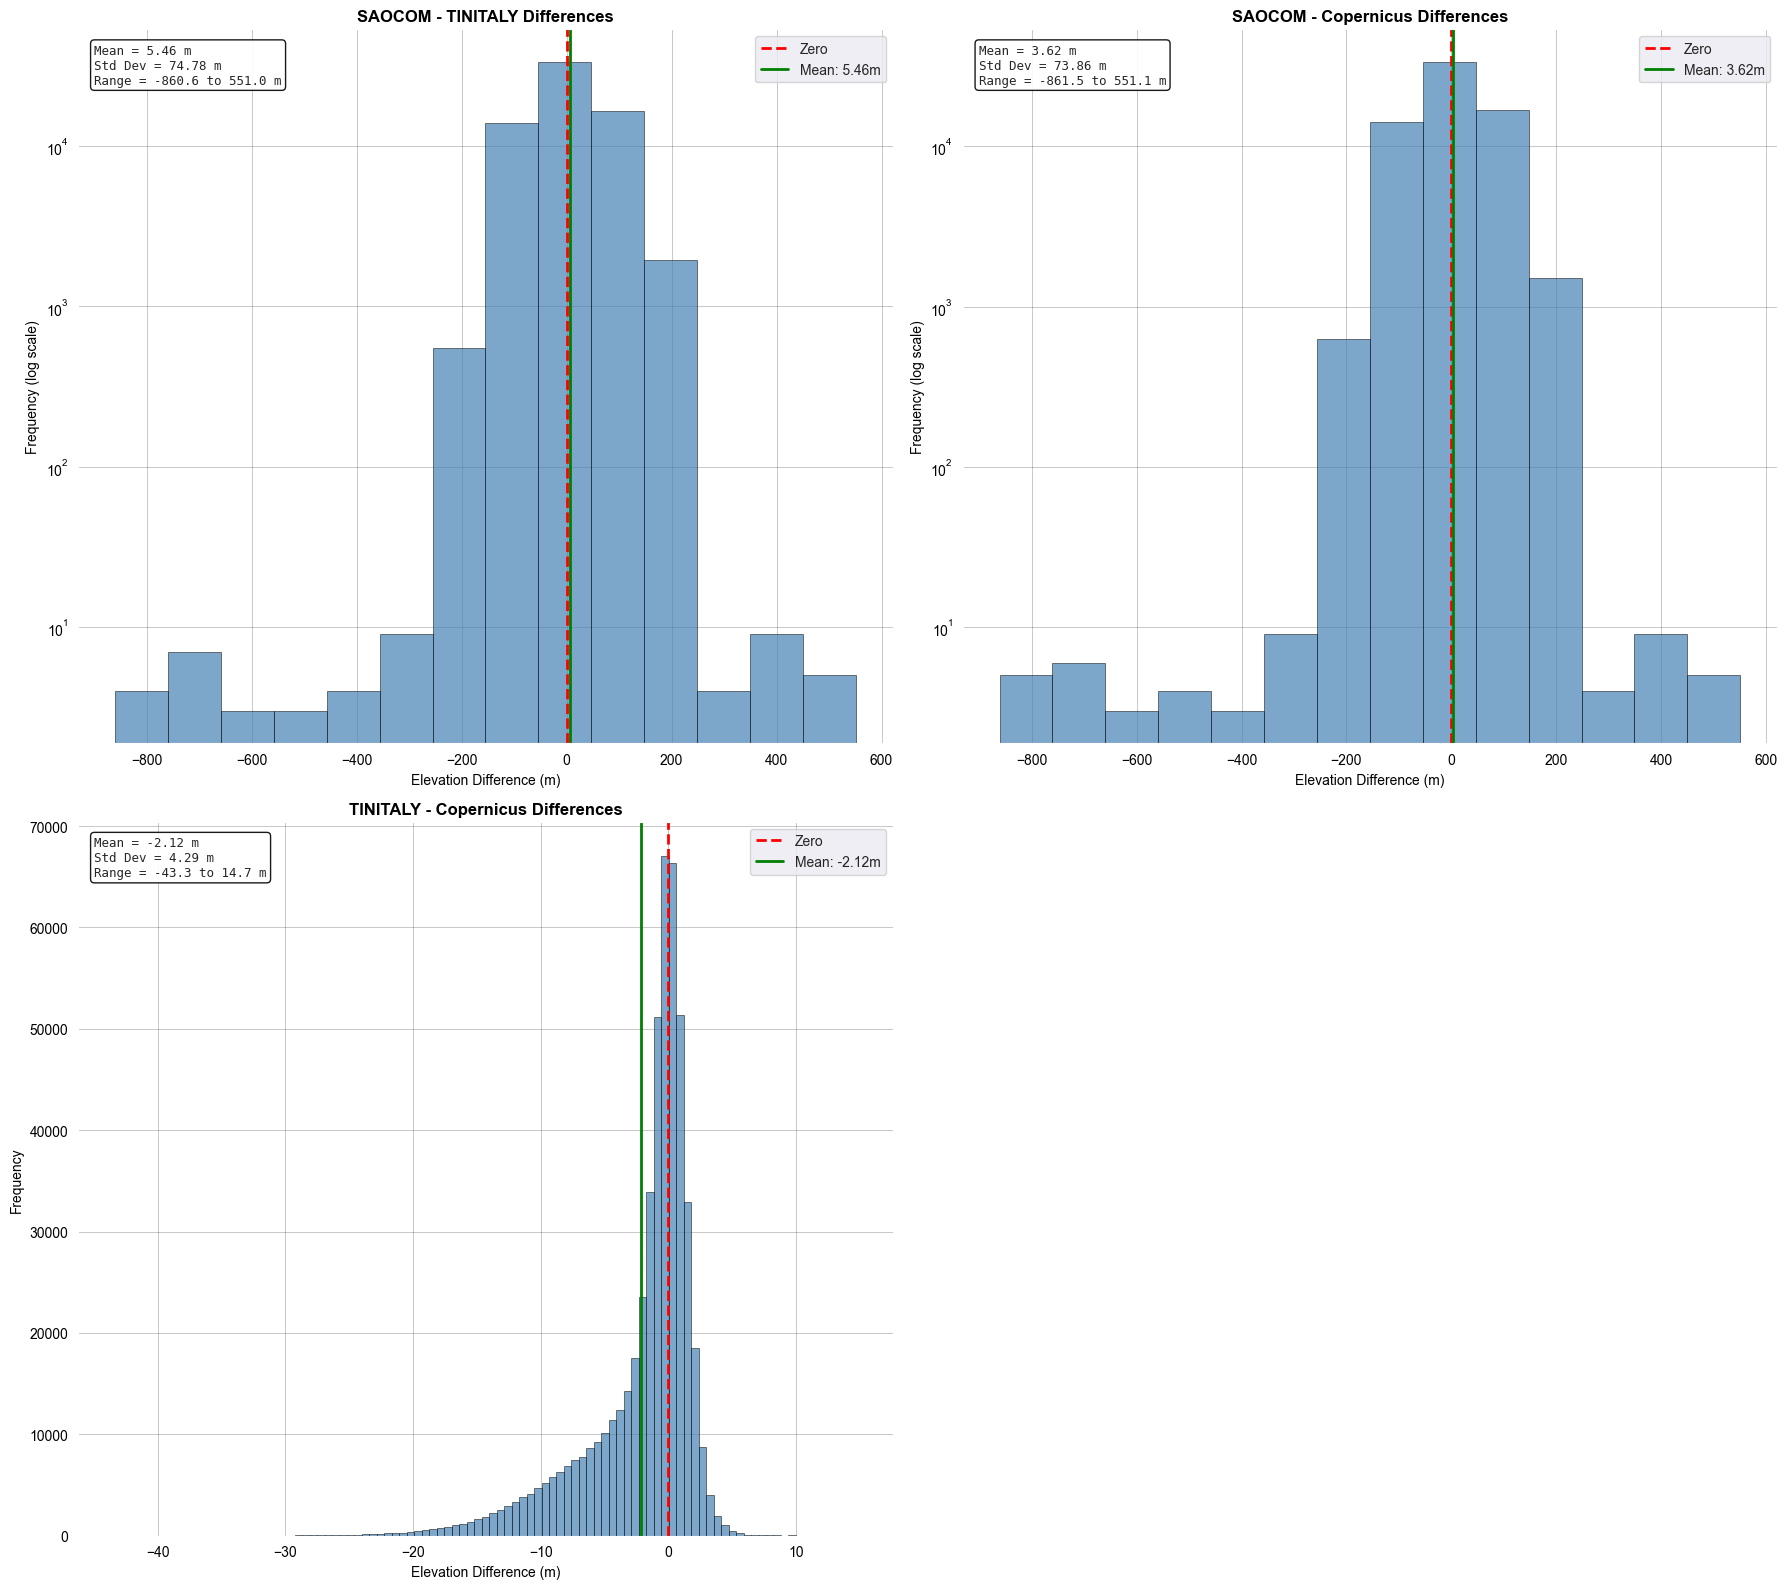

In [61]:
# =============================================================================
# HISTOGRAM COMPARISONS - CONTINUOUS BINS
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(18, 16), facecolor='white')

# Plot 1: SAOCOM - TINITALY
ax = axes[0, 0]
ax.set_facecolor('white')
bins = np.linspace(saocom_tinitaly_diff.min(), saocom_tinitaly_diff.max(), 15)
ax.hist(saocom_tinitaly_diff, bins=bins, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax.axvline(saocom_tinitaly_metrics['mean_diff'], color='green', linestyle='-', linewidth=2,
           label=f"Mean: {saocom_tinitaly_metrics['mean_diff']:.2f}m")
ax.set_xlabel('Elevation Difference (m)', color='black')
ax.set_ylabel('Frequency (log scale)', color='black')
ax.set_yscale('log')
ax.set_title('SAOCOM - TINITALY Differences', fontweight='bold', fontsize=12, color='black')
ax.tick_params(colors='black')
ax.legend()
ax.grid(True, alpha=0.3, color='black', linewidth=0.5)
stats_text = f"""Mean = {saocom_tinitaly_metrics['mean_diff']:.2f} m
Std Dev = {saocom_tinitaly_metrics['std_diff']:.2f} m
Range = {saocom_tinitaly_metrics['min_diff']:.1f} to {saocom_tinitaly_metrics['max_diff']:.1f} m"""
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 2: SAOCOM - Copernicus
ax = axes[0, 1]
ax.set_facecolor('white')
bins = np.linspace(saocom_copernicus_diff.min(), saocom_copernicus_diff.max(), 15)
ax.hist(saocom_copernicus_diff, bins=bins, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax.axvline(saocom_copernicus_metrics['mean_diff'], color='green', linestyle='-', linewidth=2,
           label=f"Mean: {saocom_copernicus_metrics['mean_diff']:.2f}m")
ax.set_xlabel('Elevation Difference (m)', color='black')
ax.set_ylabel('Frequency (log scale)', color='black')
ax.set_yscale('log')
ax.set_title('SAOCOM - Copernicus Differences', fontweight='bold', fontsize=12, color='black')
ax.tick_params(colors='black')
ax.legend()
ax.grid(True, alpha=0.3, color='black', linewidth=0.5)
stats_text = f"""Mean = {saocom_copernicus_metrics['mean_diff']:.2f} m
Std Dev = {saocom_copernicus_metrics['std_diff']:.2f} m
Range = {saocom_copernicus_metrics['min_diff']:.1f} to {saocom_copernicus_metrics['max_diff']:.1f} m"""
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 3: TINITALY - Copernicus
ax = axes[1, 0]
ax.set_facecolor('white')
bins = np.linspace(valid_diffs.min(), valid_diffs.max(), 100)
ax.hist(valid_diffs, bins=bins, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax.axvline(ref_metrics['mean_diff'], color='green', linestyle='-', linewidth=2,
           label=f"Mean: {ref_metrics['mean_diff']:.2f}m")
ax.set_xlabel('Elevation Difference (m)', color='black')
ax.set_ylabel('Frequency', color='black')
ax.set_title('TINITALY - Copernicus Differences', fontweight='bold', fontsize=12, color='black')
ax.tick_params(colors='black')
ax.legend()
ax.grid(True, alpha=0.3, color='black', linewidth=0.5)
stats_text = f"""Mean = {ref_metrics['mean_diff']:.2f} m
Std Dev = {ref_metrics['std_diff']:.2f} m
Range = {ref_metrics['min_diff']:.1f} to {ref_metrics['max_diff']:.1f} m"""
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Hide unused subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

ValueError: All arrays must be of the same length

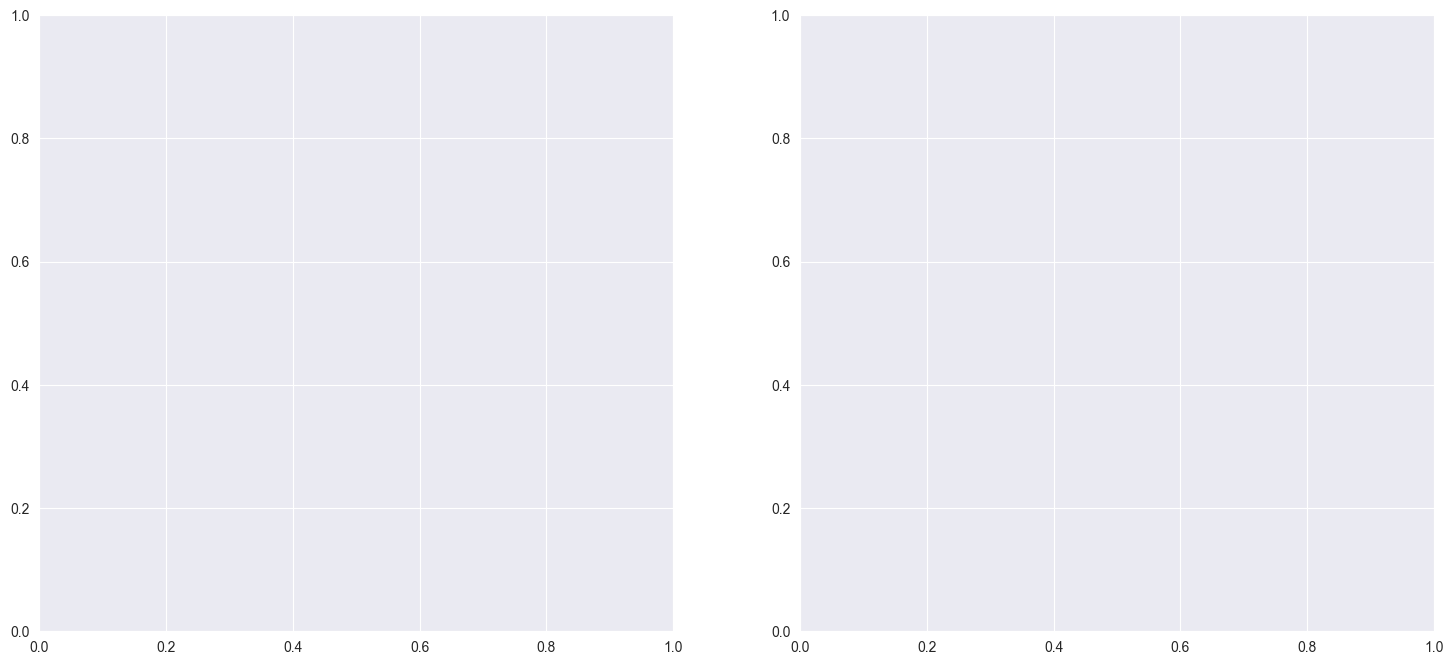

In [57]:
# =============================================================================
# VIOLIN PLOTS - ELEVATION DIFFERENCES
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 8), facecolor='white')

# Prepare data
violin_data = pd.DataFrame({
    'SAOCOM - TINITALY': saocom_tinitaly_diff,
    'SAOCOM - Copernicus': saocom_copernicus_diff,
    'TINITALY - Copernicus': valid_diffs
})

# Plot 1: All three comparisons
ax = axes[0]
ax.set_facecolor('white')
parts = ax.violinplot([saocom_tinitaly_diff, saocom_copernicus_diff, valid_diffs],
                       positions=[1, 2, 3], showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('steelblue')
    pc.set_alpha(0.7)
ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['SAOCOM -\nTINITALY', 'SAOCOM -\nCopernicus', 'TINITALY -\nCopernicus'], color='black')
ax.set_ylabel('Elevation Difference (m)', color='black')
ax.set_title('Elevation Difference Distributions', fontweight='bold', fontsize=12, color='black')
ax.tick_params(colors='black')
ax.grid(True, alpha=0.3, color='black', linewidth=0.5, axis='y')
for spine in ax.spines.values():
    spine.set_edgecolor('black')

# Plot 2: Statistics table
ax = axes[1]
ax.set_facecolor('white')
ax.axis('off')
table_data = [
    ['Metric', 'SAOCOM-TIN', 'SAOCOM-COP', 'TIN-COP'],
    ['N Points', f"{saocom_tinitaly_metrics['n_points']:,}",
     f"{saocom_copernicus_metrics['n_points']:,}", f"{ref_metrics['n_pixels']:,}"],
    ['Mean (m)', f"{saocom_tinitaly_metrics['mean_diff']:+.2f}",
     f"{saocom_copernicus_metrics['mean_diff']:+.2f}", f"{ref_metrics['mean_diff']:+.2f}"],
    ['Median (m)', f"{saocom_tinitaly_metrics['median_diff']:+.2f}",
     f"{saocom_copernicus_metrics['median_diff']:+.2f}", f"{ref_metrics['median_diff']:+.2f}"],
    ['Std Dev (m)', f"{saocom_tinitaly_metrics['std_diff']:.2f}",
     f"{saocom_copernicus_metrics['std_diff']:.2f}", f"{ref_metrics['std_diff']:.2f}"],
    ['RMSE (m)', f"{saocom_tinitaly_metrics['rmse']:.2f}",
     f"{saocom_copernicus_metrics['rmse']:.2f}", f"{ref_metrics['rmse']:.2f}"],
    ['MAE (m)', f"{saocom_tinitaly_metrics['mae']:.2f}",
     f"{saocom_copernicus_metrics['mae']:.2f}", f"{ref_metrics['mae']:.2f}"],
    ['NMAD (m)', f"{saocom_tinitaly_metrics['nmad']:.2f}",
     f"{saocom_copernicus_metrics['nmad']:.2f}", f"{ref_metrics['nmad']:.2f}"],
]
table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor('#4472C4')
        cell.set_text_props(weight='bold', color='white')
    else:
        cell.set_facecolor('white')
        cell.set_text_props(color='black')
    cell.set_edgecolor('black')
ax.set_title('Comparison Statistics', fontweight='bold', fontsize=12, color='black', pad=20)

plt.tight_layout()
plt.show()

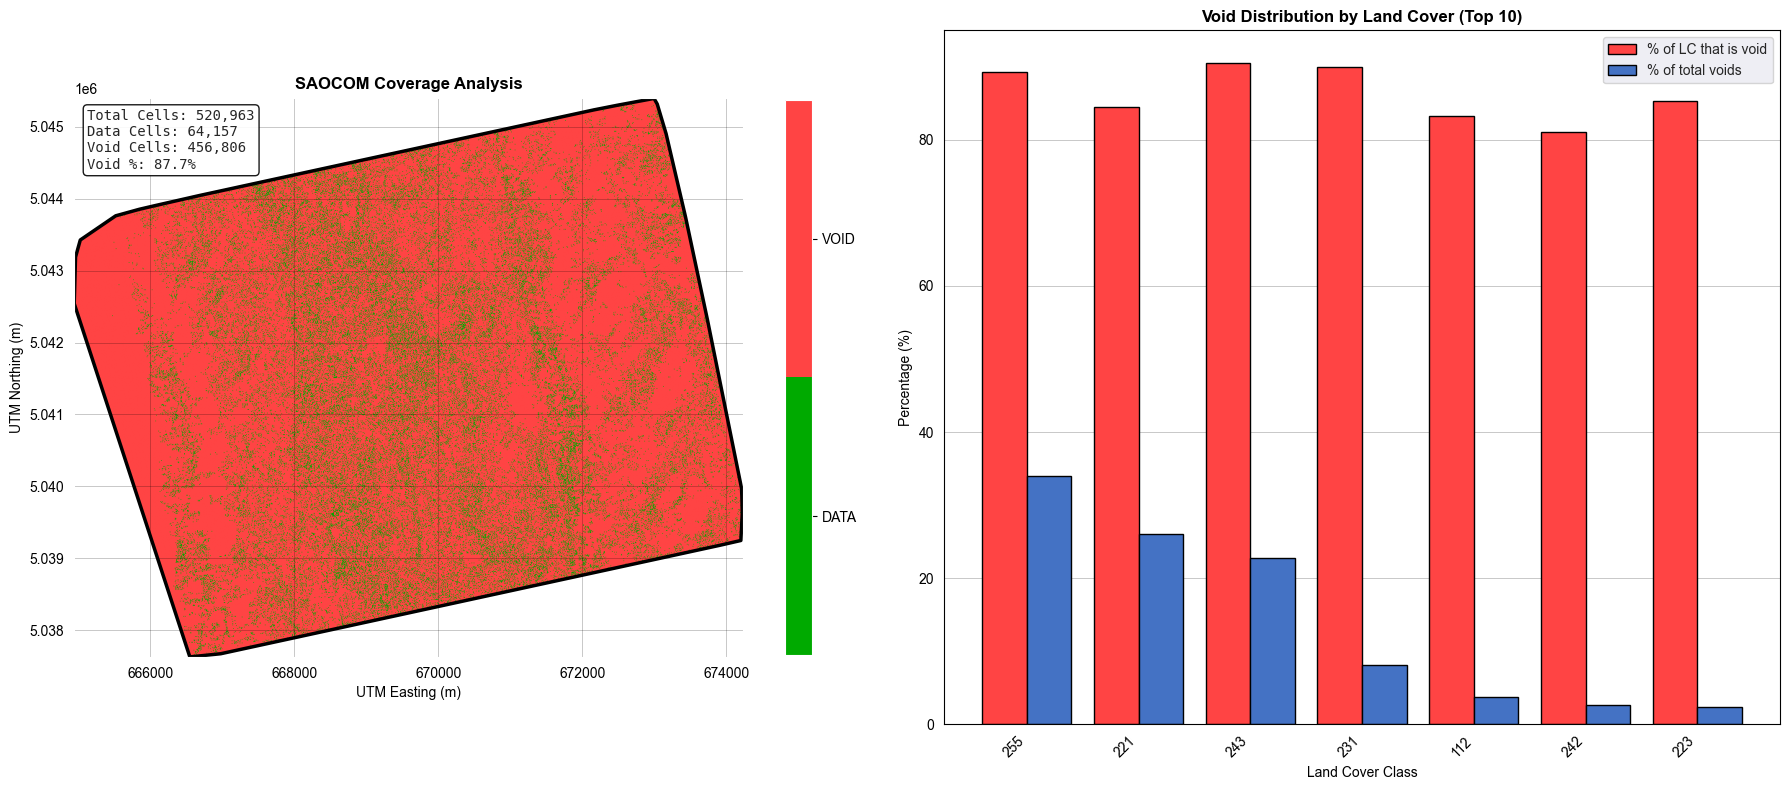

In [58]:
# =============================================================================
# SAOCOM VOID ZONE VISUALIZATION
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 8), facecolor='white')

extent = [xmin_grid, xmax_grid, ymin_grid, ymax_grid]

# Plot 1: Void mask map
ax = axes[0]
ax.set_facecolor('white')
void_display = np.full((grid_height, grid_width), np.nan)
void_display[study_area_mask] = 0  # Data available
void_display[void_mask] = 1  # Void
cmap_void = ListedColormap(['#00AA00', '#FF4444'])
cmap_void.set_bad(color='white', alpha=0)
im = ax.imshow(np.ma.masked_invalid(void_display), cmap=cmap_void, origin='upper', extent=extent)
hull_gdf.boundary.plot(ax=ax, color='black', linewidth=2.5, label='Study Area')
ax.set_title('SAOCOM Coverage Analysis', fontweight='bold', fontsize=12, color='black')
ax.set_xlabel('UTM Easting (m)', color='black')
ax.set_ylabel('UTM Northing (m)', color='black')
ax.grid(True, color='black', alpha=0.3, linewidth=0.5)
ax.tick_params(colors='black')
cbar = plt.colorbar(im, ax=ax, ticks=[0.25, 0.75], shrink=0.8)
cbar.set_ticklabels(['DATA', 'VOID'])
cbar.ax.tick_params(colors='black')
stats_text = f"""Total Cells: {n_total_cells:,}
Data Cells: {n_occupied_cells:,}
Void Cells: {n_void_cells:,}
Void %: {void_percentage:.1f}%"""
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10, verticalalignment='top',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Plot 2: Void statistics by land cover (top 10)
ax = axes[1]
ax.set_facecolor('white')
top_lc = void_stats_df.head(10)
x_pos = np.arange(len(top_lc))
bar1 = ax.bar(x_pos - 0.2, top_lc['pct_of_lc_that_is_void'], 0.4,
              label='% of LC that is void', color='#FF4444', edgecolor='black')
bar2 = ax.bar(x_pos + 0.2, top_lc['pct_of_total_voids'], 0.4,
              label='% of total voids', color='#4472C4', edgecolor='black')
ax.set_xlabel('Land Cover Class', color='black')
ax.set_ylabel('Percentage (%)', color='black')
ax.set_title('Void Distribution by Land Cover (Top 10)', fontweight='bold', fontsize=12, color='black')
ax.set_xticks(x_pos)
ax.set_xticklabels([f"{row['corine_code']}" for _, row in top_lc.iterrows()],
                    rotation=45, ha='right', color='black')
ax.tick_params(colors='black')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, color='black', linewidth=0.5, axis='y')
for spine in ax.spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()